# data loading

In [52]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance

In [2]:
# loading the data
data_train = pd.read_csv('../data/pml-training.csv', low_memory=False, index_col=0)
data_test = pd.read_csv('../data/pml-testing.csv', low_memory=False, index_col=0)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19622 entries, 1 to 19622
Columns: 159 entries, user_name to classe
dtypes: float64(94), int64(28), object(37)
memory usage: 24.0+ MB


# data cleaning

In [3]:
feature_cols = data_train.columns.to_list()
feature_cols.remove('classe')
data_train.head()

,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,...,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,classe
1,carlitos,1323084231,788290,05/12/2011 11:23,no,11,1.41,8.07,-94.4,3,...,0.03,0.00,-0.02,192,203,-215,-17,654.0,476.0,A
2,carlitos,1323084231,808298,05/12/2011 11:23,no,11,1.41,8.07,-94.4,3,...,0.02,0.00,-0.02,192,203,-216,-18,661.0,473.0,A
3,carlitos,1323084231,820366,05/12/2011 11:23,no,11,1.42,8.07,-94.4,3,...,0.03,-0.02,0.00,196,204,-213,-18,658.0,469.0,A
4,carlitos,1323084232,120339,05/12/2011 11:23,no,12,1.48,8.05,-94.4,3,...,0.02,-0.02,0.00,189,206,-214,-16,658.0,469.0,A
5,carlitos,1323084232,196328,05/12/2011 11:23,no,12,1.48,8.07,-94.4,3,...,0.02,0.00,-0.02,189,206,-214,-17,655.0,473.0,A


In [4]:
# we can safely remove user_name, raw_timestamp_part_1, raw_timestamp_part_2, cvtd_timestamp
# from feature_cols as it's just a decription feature not prredictive
feature_cols = [i for i in feature_cols if i not in ['user_name', 'raw_timestamp_part_1', 'raw_timestamp_part_2', 'cvtd_timestamp']]

In [5]:
# we can see that 100 columns have 97% of missing values. We can safely drop thrm from predictiove features
data_train.isna().mean().sort_values(ascending=False)[:101]*100

amplitude_roll_arm       97.930894
skewness_pitch_arm       97.930894
skewness_roll_forearm    97.930894
amplitude_yaw_arm        97.930894
amplitude_pitch_arm      97.930894
                           ...    
avg_yaw_forearm          97.930894
stddev_yaw_forearm       97.930894
var_yaw_forearm          97.930894
var_roll_forearm         97.930894
magnet_forearm_x          0.000000
Length: 101, dtype: float64

In [6]:
missing_cols = data_train.columns[data_train.isna().mean() >= 0.97]
feature_cols = [i for i in feature_cols if i not in missing_cols]

In [7]:
# good for us, all other 54 features don't have missing values at all!
data_train[feature_cols].columns.isna()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [8]:
# here we will check for columns that have only 1 unique value for all data set
# we can see there is no such columns
threshold = 1
low_unique_cols = [col for col in feature_cols if data_train[col].nunique() <= threshold]
print(low_unique_cols)

[]


In [9]:
# categorical features
# we can see that we have only 1 categorical feature -- new_window
data_train[feature_cols].select_dtypes(include='object')

,new_window
1,no
2,no
3,no
4,no
5,no
...,...
19618,no
19619,no
19620,no
19621,no


In [10]:
# we can see that new_window has 97% of same value and near zero variance
# that is why we are droping it from predictors too
print(data_train['new_window'].value_counts(normalize=True)*100)
print('variance', data_train['new_window'].map({'no':0,'yes':1}).var())

feature_cols.remove('new_window')

# we can remove num_window too as it's just a decription feature of an experiments not a predictor
feature_cols.remove('num_window')

no     97.930894
yes     2.069106
Name: new_window, dtype: float64
variance 0.0202639737634223


In [11]:
# lets find other fetures that have near zero variance
from sklearn.feature_selection import VarianceThreshold

# Define the threshold for variance
threshold = 0.005

# Select features with variance above the defined threshold
selector = VarianceThreshold(threshold)
selected_features = selector.fit_transform(data_train[feature_cols])

# Get the names of the selected features
mask = selector.get_support()
feature_names = data_train[feature_cols].columns[mask]

print([i for i in feature_cols if i not in feature_names])

[]


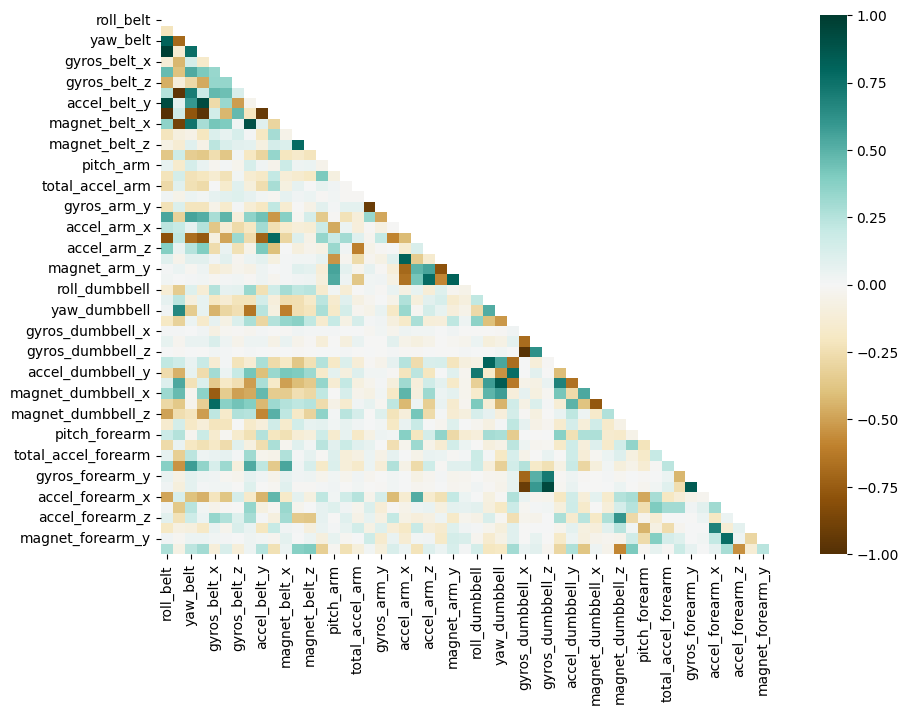

In [12]:
# lets look at correlation between fetures

# applying mask
plt.figure(figsize=(10, 7))
mask = np.triu(np.ones_like(data_train[feature_cols].corr()))
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(data_train[feature_cols].corr(), mask=mask, vmin=-1, vmax=1, cmap='BrBG')
# displaying heatmap
plt.show()

In [13]:
# we can defenitely see that some fetures are highly correleted so lets remove them
corr_df = data_train[feature_cols].corr().abs()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
t_df = corr_df.mask(mask)

In [14]:
t_df

,roll_belt,pitch_belt,yaw_belt,total_accel_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,...,total_accel_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z
roll_belt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pitch_belt,0.215925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yaw_belt,0.815230,0.699752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_accel_belt,0.980924,0.138981,0.762096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gyros_belt_x,0.117470,0.435964,0.145048,0.165311,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gyros_belt_y,0.463718,0.397112,0.530045,0.409315,0.333146,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gyros_belt_z,0.459038,0.106988,0.274983,0.475373,0.339675,0.342206,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accel_belt_x,0.256835,0.965733,0.708028,0.172264,0.474327,0.447209,0.117253,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accel_belt_y,0.924898,0.081519,0.600547,0.927807,0.268518,0.327531,0.507896,0.036840,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accel_belt_z,0.992009,0.161850,0.776452,0.974932,0.151316,0.433695,0.471988,0.209370,0.933385,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
to_drop = [i for i in t_df.columns if any(t_df[i]>0.95)]
feature_cols = [i for i in feature_cols if i not in to_drop]
print('features that have correlation > 0.95 to some other feature \n', to_drop)

features that have correlation > 0.95 to some other feature 
 ['roll_belt', 'pitch_belt', 'total_accel_belt', 'gyros_dumbbell_x']


# Modeling

In [16]:
# lets look at our data after cleaning
data_train[feature_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19622 entries, 1 to 19622
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   yaw_belt              19622 non-null  float64
 1   gyros_belt_x          19622 non-null  float64
 2   gyros_belt_y          19622 non-null  float64
 3   gyros_belt_z          19622 non-null  float64
 4   accel_belt_x          19622 non-null  int64  
 5   accel_belt_y          19622 non-null  int64  
 6   accel_belt_z          19622 non-null  int64  
 7   magnet_belt_x         19622 non-null  int64  
 8   magnet_belt_y         19622 non-null  int64  
 9   magnet_belt_z         19622 non-null  int64  
 10  roll_arm              19622 non-null  float64
 11  pitch_arm             19622 non-null  float64
 12  yaw_arm               19622 non-null  float64
 13  total_accel_arm       19622 non-null  int64  
 14  gyros_arm_x           19622 non-null  float64
 15  gyros_arm_y        

In [17]:
# lets look at our target variable
data_train['classe'].value_counts(normalize=True)*100

A    28.437468
B    19.350729
E    18.382428
C    17.439609
D    16.389767
Name: classe, dtype: float64

In [18]:
# we can see that target variable not severely skewed hense we can use accuracy as a metric!

In [19]:
# let's split into train and delay set (train set will be than split into train and val while cross-val)

X_train, X_test, y_train, y_test = train_test_split(data_train[feature_cols], 
                                                    data_train['classe'], test_size=0.2, random_state=42)

# for modelling we are going to use RandomForestClassifier 
# as it's a very good first choice for any tabular data
clf = RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=20)

# for evaluation we will use kfold cross-validation
cv = KFold(n_splits=5,random_state=42, shuffle=True)
results = cross_validate(clf, X_train, y_train, scoring='accuracy', cv=cv, return_train_score=True)

print('train accuracy', np.mean(results['train_score']))
print('val accuracy', np.mean(results['test_score']))
print('overgitting', np.mean(results['train_score']) - np.mean(results['test_score']))

train accuracy 0.9997929517843925
val accuracy 0.991208567781942
overgitting 0.00858438400245054


In [20]:
# lets tune max_depth hyperparametr
cv = KFold(n_splits=5,random_state=42, shuffle=True)
train_acc = []
val_acc = []
for i in range(15, 40):
    
    clf = RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=i)
    results = cross_validate(clf, X_train, y_train, scoring='accuracy', cv=cv, return_train_score=True)
    train_acc.append(np.mean(results['train_score']))
    val_acc.append(np.mean(results['test_score']))
    
    print('-'*40)
    print(f'max_depth=={i}')
    print('train accuracy', np.mean(results['train_score']))
    print('val accuracy', np.mean(results['test_score']))
    print('overgitting', np.mean(results['train_score']) - np.mean(results['test_score']))

----------------------------------------
max_depth==15
train accuracy 0.995731675060371
val accuracy 0.9810157805134907
overgitting 0.01471589454688027
----------------------------------------
max_depth==16
train accuracy 0.9977702694981468
val accuracy 0.9858574173689133
overgitting 0.011912852129233542
----------------------------------------
max_depth==17
train accuracy 0.9988054978931364
val accuracy 0.987704896078308
overgitting 0.011100601814828415
----------------------------------------
max_depth==18
train accuracy 0.999394782724365
val accuracy 0.9891701077263033
overgitting 0.010224674998061678
----------------------------------------
max_depth==19
train accuracy 0.9996177570428552
val accuracy 0.990380542304235
overgitting 0.009237214738620159
----------------------------------------
max_depth==20
train accuracy 0.9997929517843925
val accuracy 0.991208567781942
overgitting 0.00858438400245054
----------------------------------------
max_depth==21
train accuracy 0.99988851347

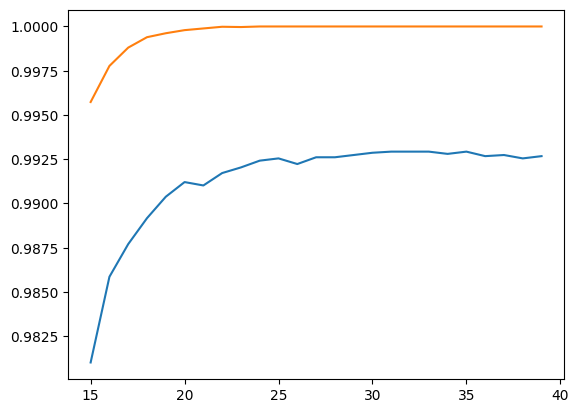

In [21]:
# lets plot our train and val curve
x = list(range(15, 40))
plt.plot(x, val_acc)
plt.plot(x, train_acc)
plt.show()

In [22]:
# we can find best max_depth like that
list(range(15, 40))[np.argmax(val_acc)]

35

In [23]:
# lets predict to the delay set
clf = RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=35)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

print('accuracy_score', accuracy_score(y_test, prediction))

accuracy_score 0.9943949044585987


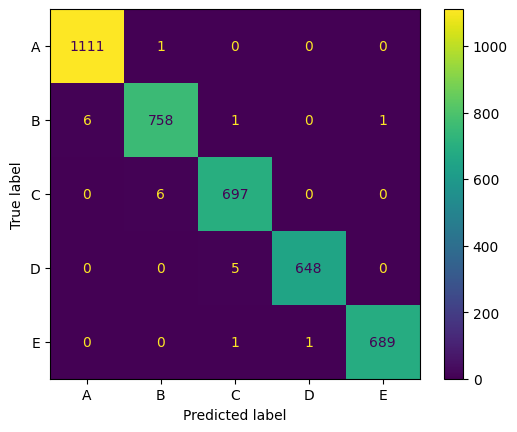

In [24]:
# lets plot a cinfusion matrix
cnf_m=confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(cnf_m,display_labels=['A','B','C','D','E'])
disp.plot()
plt.show()

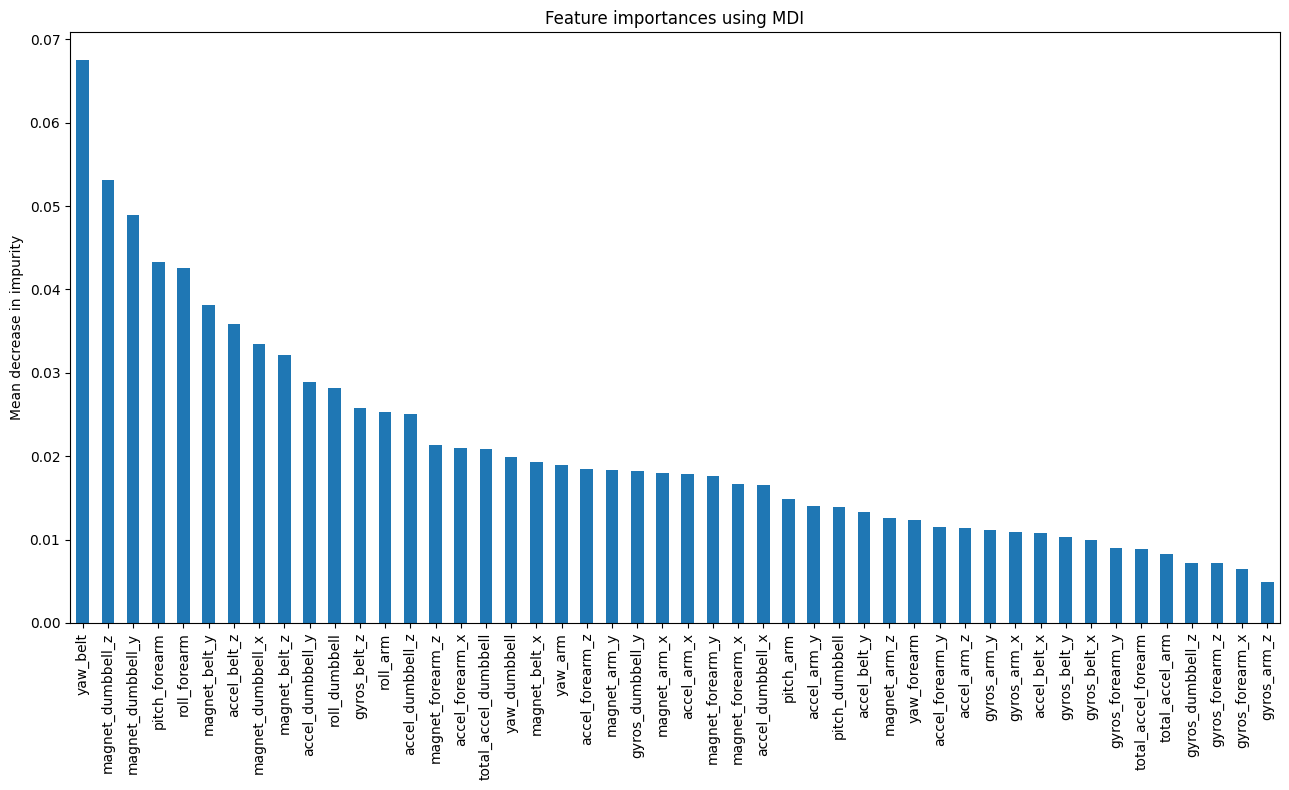

In [51]:
# lets look at feature importance of a final model
importances = clf.feature_importances_

forest_importances = pd.Series(importances, index=feature_cols)
forest_importances = forest_importances.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(13, 8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

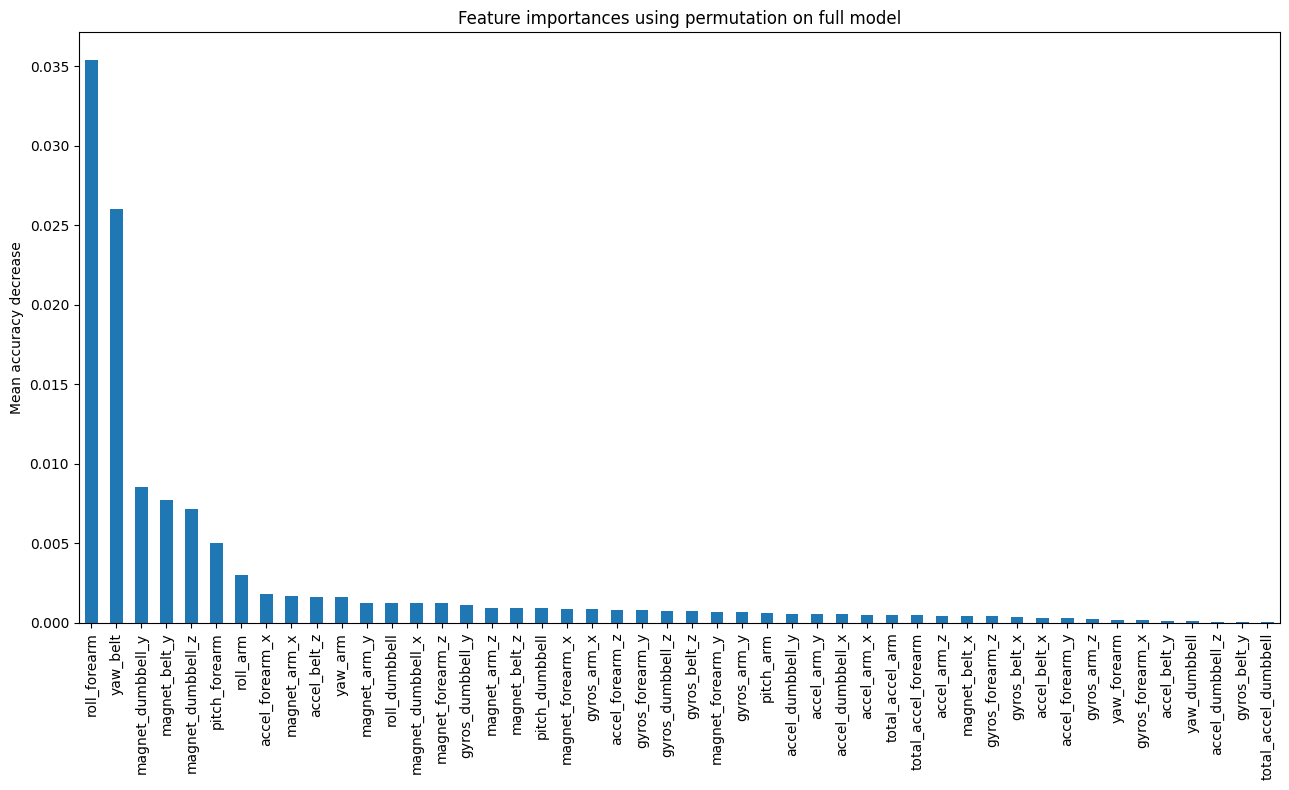

In [58]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
forest_importances = pd.Series(result.importances_mean, index=feature_cols)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(13, 8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# predicting to data_test

In [61]:
data_test['classe'] = clf.predict(data_test[feature_cols])

In [67]:
data_test.to_csv('prediction.csv')